In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from scipy.stats import chi2

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

df = pd.read_csv('result.csv')

active=[i for i in df.columns if "Active_" in i]
bowel=[i for i in df.columns if"Bowel Movements_" in i]
creative=[i for i in df.columns if "Creative_" in i]
lifestyle=[i for i in df.columns if "Lifestyle_" in i]
meds=[i for i in df.columns if "Meds/Supplements_" in i]
energy=[i for i in df.columns if "Energy_" in i]
mood=[i for i in df.columns if "Mood_" in i]
nutrition=[i for i in df.columns if "Nutrition_" in i]
sleep=[i for i in df.columns if "Sleep_" in i]

symptom=[i for i in df.columns if "Symptom_" in i]
weather=[i for i in df.columns if "Weather_" in i]
sleep_metrics=['deep_sleep','efficiency_x','latency','rem_sleep','restfulness','timing','total_sleep']  #what is efficiency y?
hrv=['average_breath','average_heart_rate','average_hrv','lowest_heart_rate']
sleep_times=['awake_time','deep_sleep_duration','latency_duration','light_sleep_duration','rem_sleep_duration','restless_periods','time_in_bed','total_sleep_duration']
readiness=[i for i in df.columns if "readiness_" in i]

sleep=['Sleep_Blue','Sleep_Drink water before bed','Sleep_Early Bedtime','Sleep_Fan on','Sleep_Individual blanket','Sleep_Late Bedtime','Sleep_Screentime 1h from bedtime','day_of_week','is_weekend']
y_var='score'
x_var=sleep
X=df[x_var]
y=np.array(df[y_var]).reshape(-1,1)
print(X.shape)
print(y.shape)

(164, 9)
(164, 1)


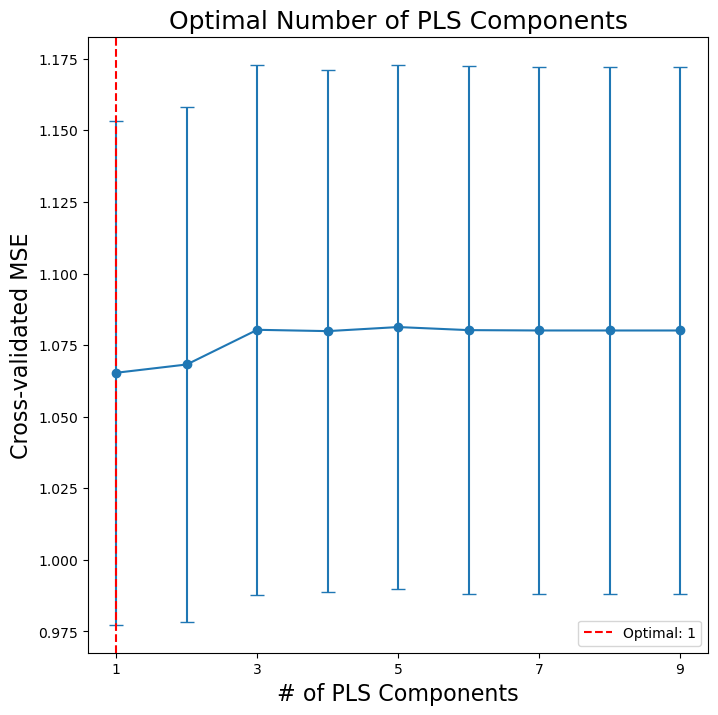

(1, 3)

In [9]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)#

K = 5
kfold = KFold(K,
random_state=0,
shuffle=True)

pls=PLSRegression()

param_grid={'n_components':range(1,min(20,X_scaled.shape[1]+1))}
grid=GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_scaled,y_scaled)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.axvline(optimal_n_components, color='r', linestyle='--', label=f'Optimal: {optimal_n_components}')
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("Optimal Number of PLS Components", fontsize=18)
plt.legend()
plt.show()

# Fit PLS with the optimal number of components
pls_final = PLSRegression(n_components=3)
pls_final.fit(X_scaled, y_scaled)
pls_final.y_loadings_.shape

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.9999999999999998
0.021910867038636244


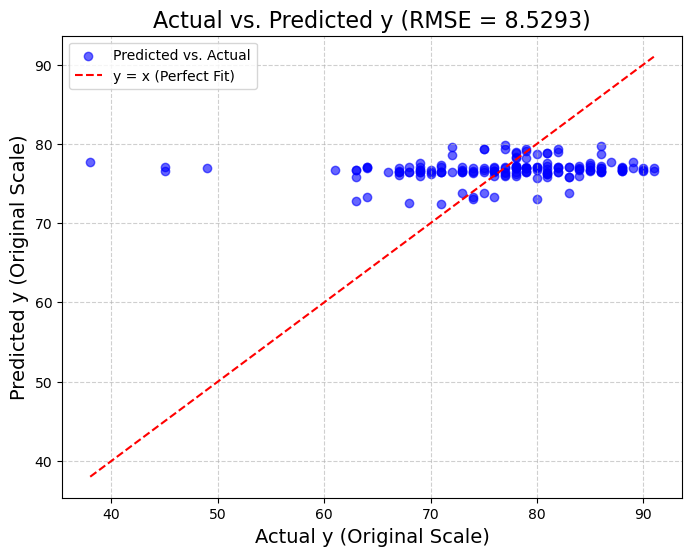

RMSE (Original Scale): 8.5293
R2_X (Explained Variance in X): 0.2877
R2_Y (Explained Variance in Y): 0.0219


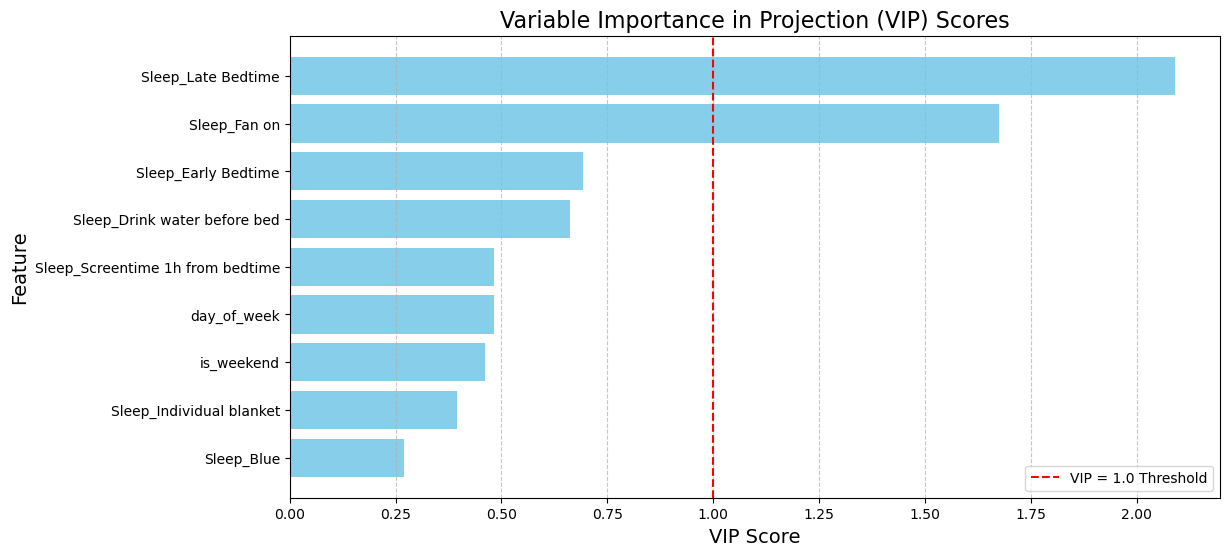

In [12]:
pls_final = PLSRegression(n_components=3)
pls_final.fit(X_scaled, y_scaled)
y_pred = pls_final.predict(X_scaled)  # Predictions in standardized form
y_pred_original = scaler_y.inverse_transform(y_pred)  # Convert back

# Compute RMSE in original scale
rmse_original = mean_squared_error(y, y_pred_original, squared=False)

# Compute R2_X (explained variance in X)
R2_X = np.var(pls_final.x_scores_, axis=0).sum() / np.var(X_scaled, axis=0).sum()

# Compute R2_Y (explained variance in Y)
total_variance_y = np.var(y_scaled)
print(total_variance_y)
variance_explained_y = np.sum((pls_final.y_loadings_ ** 2) * np.var(pls_final.x_scores_, axis=0))
print(variance_explained_y)

R2_Y = variance_explained_y / total_variance_y

# Plot actual vs. predicted y values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_original, alpha=0.6, color="blue", label="Predicted vs. Actual")
plt.plot([y.min(), y.max()], [Y.min(), Y.max()], color='red', linestyle="--", label="y = x (Perfect Fit)")
plt.xlabel("Actual y (Original Scale)", fontsize=14)
plt.ylabel("Predicted y (Original Scale)", fontsize=14)
plt.title(f"Actual vs. Predicted y (RMSE = {rmse_original:.4f})", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print performance metrics
print(f"RMSE (Original Scale): {rmse_original:.4f}")
print(f"R2_X (Explained Variance in X): {R2_X:.4f}")
print(f"R2_Y (Explained Variance in Y): {R2_Y:.4f}")

def calculate_vip(pls, X):
    """
    Compute Variable Importance in Projection (VIP) scores for PLSRegression.

    Parameters:
    - pls: Trained PLSRegression model
    - X: The original feature matrix (before scaling)

    Returns:
    - vip_scores: Array of VIP scores for each feature
    """
    t = pls.x_scores_  # PLS scores
    w = pls.x_weights_  # PLS weights
    q = pls.y_loadings_  # PLS loadings for y

    p, A = w.shape  # Number of variables (p) and components (A)

    s = np.var(t, axis=0) * (q**2).flatten()  # Variance explained per component
    total_s = np.sum(s)  # Total variance explained

    vip = np.sqrt(p * np.sum((w**2) * s.reshape(1, -1), axis=1) / total_s)
    return vip  # Convert to 1D array

    
# Compute VIP scores for the trained PLS model
vip_scores = calculate_vip(pls_final, X_scaled)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Plot VIP scores
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["VIP Score"], color="skyblue")
plt.axvline(1.0, color='r', linestyle='--', label="VIP = 1.0 Threshold")
plt.xlabel("VIP Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Variable Importance in Projection (VIP) Scores", fontsize=16)
plt.gca().invert_yaxis()  # Flip the highest values to the top
plt.legend()
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()

(164, 69)
(164, 1)


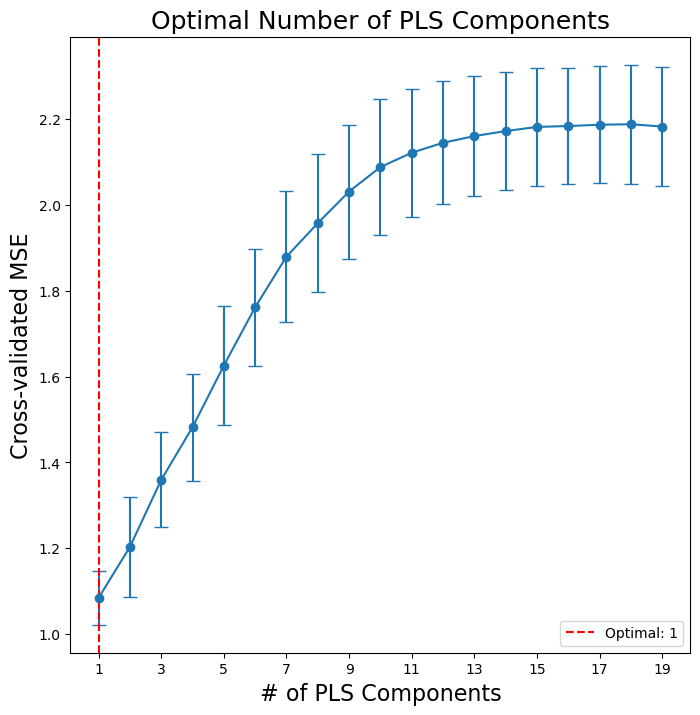

0.9999999999999998
0.2943172665259471


c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


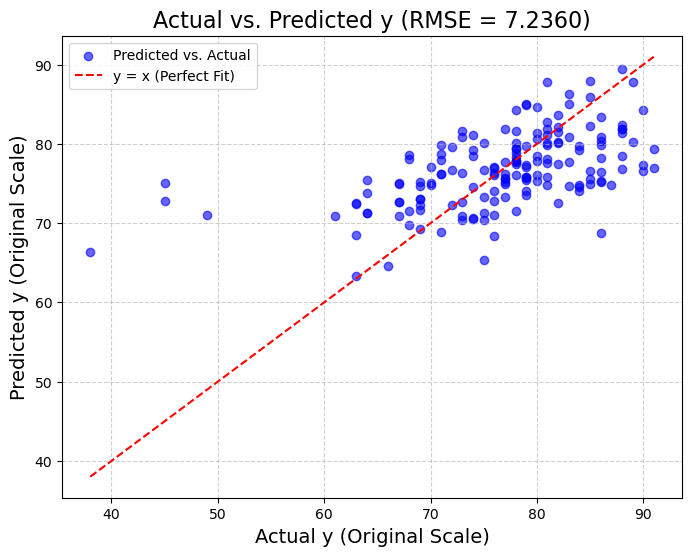

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


RMSE (Original Scale): 7.2360
R2_X (Explained Variance in X): 0.0830
R2_Y (Explained Variance in Y): 0.2943


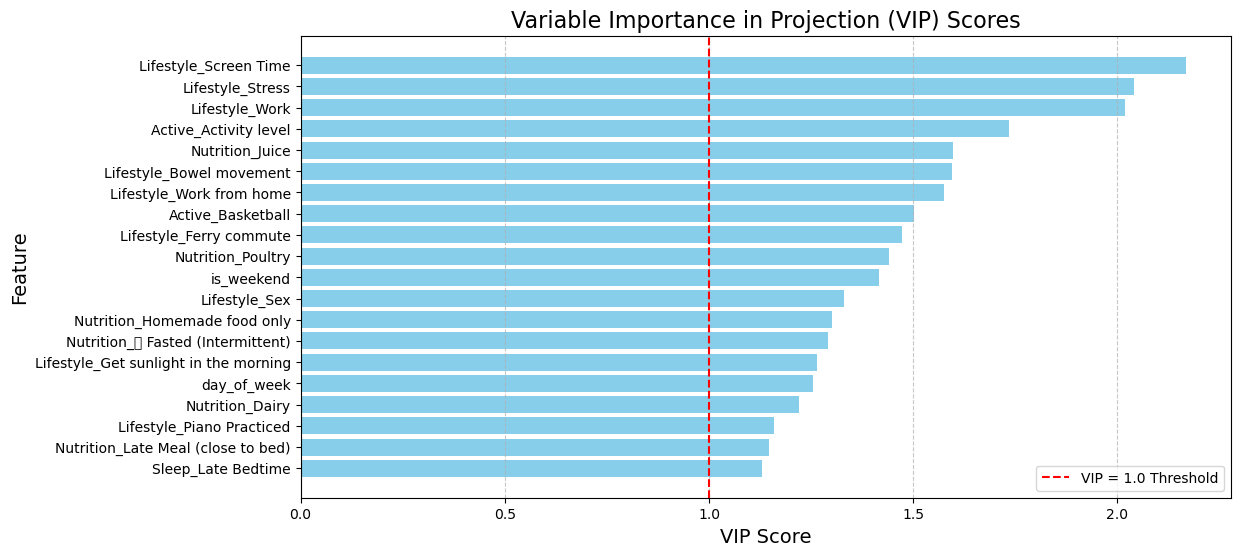

C:\Users\jhuang\AppData\Local\Temp\ipykernel_22028\4060242866.py:123: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


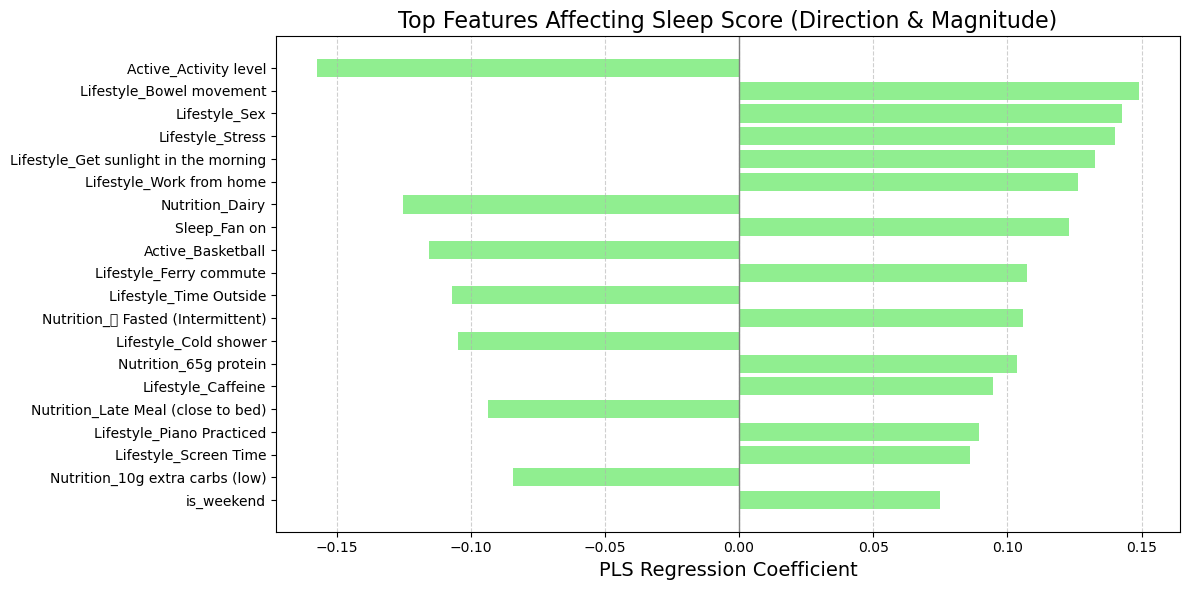

In [15]:
y_var='score'
x_var=sleep+active+lifestyle+nutrition
X=df[x_var]
Y=np.array(df[y_var]).reshape(-1,1)
print(X.shape)
print(y.shape)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(Y)#

K = 5
kfold = KFold(K,
random_state=0,
shuffle=True)

pls=PLSRegression()

param_grid={'n_components':range(1,min(20,X_scaled.shape[1]+1))}
grid=GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_scaled,y_scaled)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.axvline(optimal_n_components, color='r', linestyle='--', label=f'Optimal: {optimal_n_components}')
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("Optimal Number of PLS Components", fontsize=18)
plt.legend()
plt.show()

pls_final = PLSRegression(n_components=3)
pls_final.fit(X_scaled, y_scaled)
y_pred = pls_final.predict(X_scaled)  # Predictions in standardized form
y_pred_original = scaler_y.inverse_transform(y_pred)  # Convert back

# Compute RMSE in original scale
rmse_original = mean_squared_error(Y, y_pred_original, squared=False)

# Compute R2_X (explained variance in X)
R2_X = np.var(pls_final.x_scores_, axis=0).sum() / np.var(X_scaled, axis=0).sum()

# Compute R2_Y (explained variance in Y)
total_variance_y = np.var(y_scaled)
print(total_variance_y)
variance_explained_y = np.sum((pls_final.y_loadings_ ** 2) * np.var(pls_final.x_scores_, axis=0))
print(variance_explained_y)

R2_Y = variance_explained_y / total_variance_y

# Plot actual vs. predicted y values
plt.figure(figsize=(8, 6))
plt.scatter(Y, y_pred_original, alpha=0.6, color="blue", label="Predicted vs. Actual")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle="--", label="y = x (Perfect Fit)")
plt.xlabel("Actual y (Original Scale)", fontsize=14)
plt.ylabel("Predicted y (Original Scale)", fontsize=14)
plt.title(f"Actual vs. Predicted y (RMSE = {rmse_original:.4f})", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print performance metrics
print(f"RMSE (Original Scale): {rmse_original:.4f}")
print(f"R2_X (Explained Variance in X): {R2_X:.4f}")
print(f"R2_Y (Explained Variance in Y): {R2_Y:.4f}")

# Compute VIP scores for the trained PLS model
vip_scores = calculate_vip(pls_final, X_scaled)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Plot VIP scores
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"][:20], feature_importance_df["VIP Score"][:20], color="skyblue")
plt.axvline(1.0, color='r', linestyle='--', label="VIP = 1.0 Threshold")
plt.xlabel("VIP Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Variable Importance in Projection (VIP) Scores", fontsize=16)
plt.gca().invert_yaxis()  # Flip the highest values to the top
plt.legend()
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()

# Get regression coefficients from the final model
pls_coefficients = pls_final.coef_.flatten()

# Create a DataFrame with features and their coefficients
coefficients_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": pls_coefficients
}).sort_values(by="Coefficient", ascending=False)

# Plot top 20 features by absolute coefficient value
top_n = 20
coefficients_df['abs_coeff'] = coefficients_df['Coefficient'].abs()
top_features = coefficients_df.sort_values('abs_coeff', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_features["Feature"], top_features["Coefficient"], color="lightgreen")
plt.axvline(0, color="gray", linewidth=1)
plt.xlabel("PLS Regression Coefficient", fontsize=14)
plt.title("Top Features Affecting Sleep Score (Direction & Magnitude)", fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

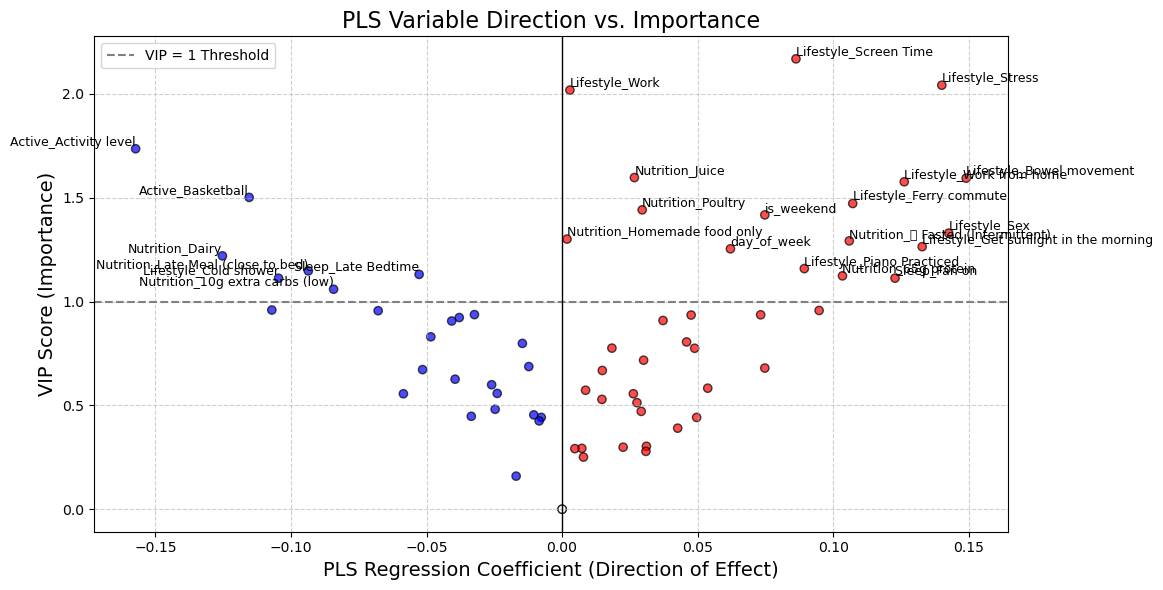

In [16]:
# Combine VIP and coefficient info into one DataFrame
vip_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores,
    "Coefficient": pls_final.coef_.flatten()
})

# Scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    vip_coef_df["Coefficient"],
    vip_coef_df["VIP Score"],
    c=np.sign(vip_coef_df["Coefficient"]),  # color by direction
    cmap="bwr",  # blue = negative, red = positive
    edgecolor='k',
    alpha=0.7
)

plt.axhline(1.0, color="gray", linestyle="--", label="VIP = 1 Threshold")
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("PLS Regression Coefficient (Direction of Effect)", fontsize=14)
plt.ylabel("VIP Score (Importance)", fontsize=14)
plt.title("PLS Variable Direction vs. Importance", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Optional: Annotate top variables
top_vars = vip_coef_df[vip_coef_df["VIP Score"] > 1.0]
for _, row in top_vars.iterrows():
    plt.text(row["Coefficient"], row["VIP Score"], row["Feature"], fontsize=9,
             ha='right' if row["Coefficient"] < 0 else 'left',
             va='bottom')

plt.show()

some utoffs. VIP > 0.8

Q2 goodness of fit.
R2_X
R2_Y

When we see disagreements between data driven approach vs subject expertise.
If tightly controlled, model may not show something that is important. Because model is only showing variability within the dataset.

What about variables that are inputs/outputs? Like recovery %

If variaibles are all related to one thing (like solids pool weight, highly inter-related. '

Question about iterating. everything will identified going 0.8>. Q2 once above 0.6, may not need to get it high as possible. THey thihk 1st pass remove variables. But don't do it 3 or 4 times.

Q2 hcking. when lots of variation, some co-variation might be picked up. Kinda like p-hacking.

Covariances can still be useful. Keep models in. Even if its not affecting the y.

In the loadings plot for OPLS.
Very left, or very right. is predictive.
around 0, not predictive. But if highly or lowly, there's covariation.

Permutation TEst. R2 and Q2 will always be good in an overfitted modl.R2 >0.3 its an overfit model.

Permutation test.

High variables in linear regressio vs MVA. Removing in or leave them in. In linear regression, simpler is better, remove variables (use degrees of freedom). 

PLS. PC1 most variance for R2 predictive regression. 
PC2. finds orthoganol (but can be many). rotate it to predictive. LV2 will have nonpredictive power to them, but might have variation that. 

VIP list. Do like top 10 if theres capacity. Don't go for anything >0.8. Look at predictive and total and see whats overlap.

Then plotting x vs ys, is switching back to univariate analysis. might not be linear. if something that has high vip but not good predictor, is there another variable that can , or some other explanation?

Qs and R2 are good. but the best is to measure performance on test set. So once gets GMP2 from capua, will plug it in and get y_actual, y_pred

In [ ]:
def confidence_ellipse(x, y, n_std=3.0, size=100):
    """
    Create a path for a confidence ellipse.
    
    Parameters:
    x (numpy.ndarray): x-coordinates of data points.
    y (numpy.ndarray): y-coordinates of data points.
    n_std (float): Number of standard deviations for the ellipse's radii.
    size (int): Number of points to generate along the ellipse path.
    
    Returns:
    str: A path string for the ellipse.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack([ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)])
    
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)
    
    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array([[np.cos(np.pi / 4), np.sin(np.pi / 4)],
                                [-np.sin(np.pi / 4), np.cos(np.pi / 4)]])
    scale_matrix = np.array([[x_scale, 0],
                             [0, y_scale]])
    ellipse_coords = ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
    
    path = f'M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}'
    for k in range(1, len(ellipse_coords)):
        path += f'L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}'
    path += ' Z'
    return path

def plot_pls_2d_latent_plotly(pls, X, y):
    """
    Plot the data points in the 2D latent variable space with a 95% confidence ellipse using Plotly.
    
    Parameters:
    pls (PLSRegression): Fitted PLS regression model.
    X (numpy.ndarray): Predictor variables.
    y (numpy.ndarray): Response variable.
    run_id (numpy.ndarray): Array of run IDs.
    """
    # Project the data into the 2D latent variable space
    X_scores = pls.x_scores_[:, :2]
    
    fig = make_subplots()
    
    # Plot the data points
    scatter = go.Scatter(
        x=X_scores[:, 0],
        y=X_scores[:, 1],
        mode='markers',
        marker=dict(color=y, colorscale='Viridis', showscale=True),
        hovertemplate='Run ID: %{text}<br>Latent Variable 1: %{x}<br>Latent Variable 2: %{y}<br>Response: %{marker.color}<extra></extra>',
        name='Data points'
    )
    fig.add_trace(scatter)
    
    # Calculate the 95% confidence ellipse
    ellipse_path = confidence_ellipse(X_scores[:, 0], X_scores[:, 1], n_std=1.96)
    
    # Add the ellipse path to the plot
    fig.add_shape(type='path', path=ellipse_path, line_color='red')
    
    fig.update_layout(
        title='PLS 2D Latent Variable Space with 95% Confidence Ellipse',
        xaxis_title='Latent Variable 1',
        yaxis_title='Latent Variable 2',
        showlegend=False
    )
    
    fig.show()


plot_pls_2d_latent_plotly(pls_model, X, y, run_id)

NameError: name 'df2' is not defined